# CNN to Detect Presence of a Fracture in X-ray Images
### Diya Vinod

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dir = "data/train"
val_dir = "data/val"
test_dir = "data/test"

## Data preprocessing
- Normalize pixels
- Data augmentation to prevent overfitting and improve generalization

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    'data/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    'data/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    'data/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle = False
)
print("Train:", train_data.class_indices)
print("Val:", val_data.class_indices)
print("Test:", test_data.class_indices)

Found 9247 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 507 images belonging to 2 classes.
Train: {'fractured': 0, 'not fractured': 1}
Val: {'fractured': 0, 'not fractured': 1}
Test: {'fractured': 0, 'not fractured': 1}


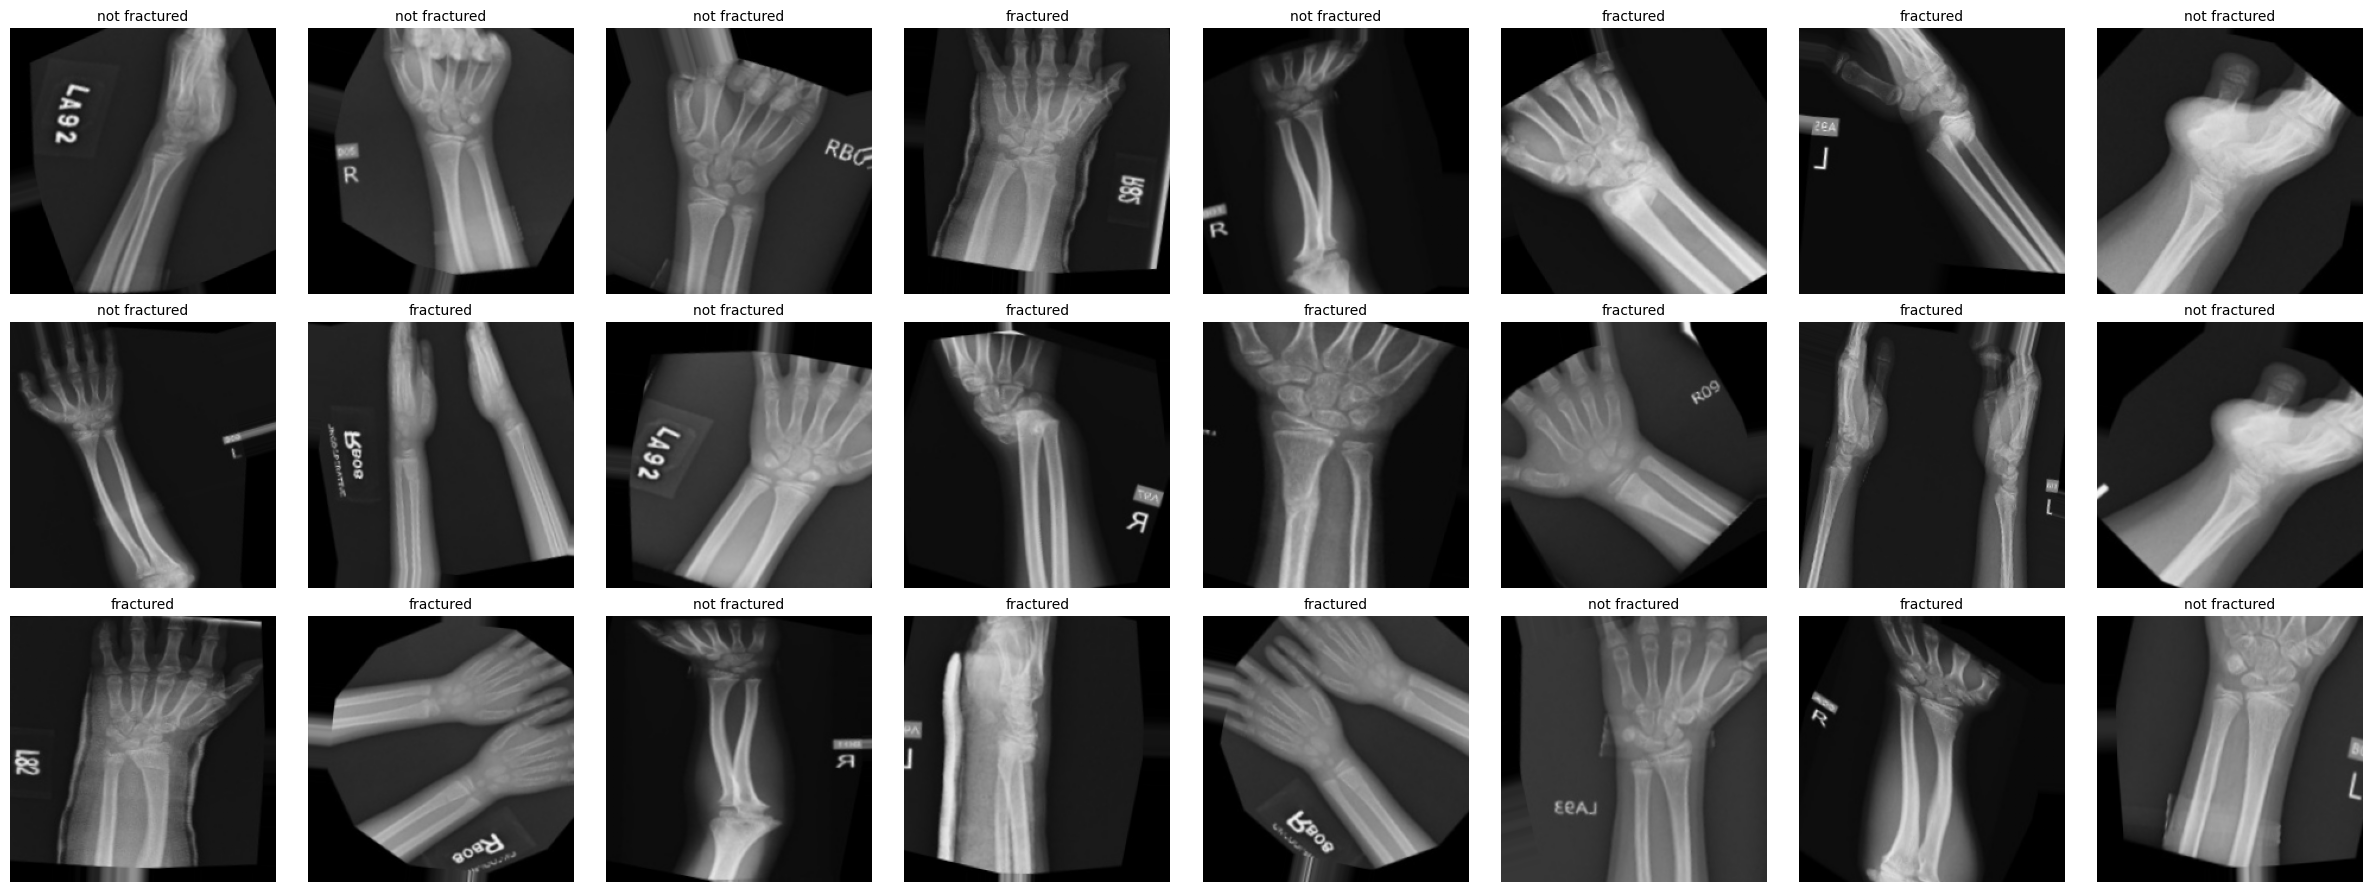

In [5]:
images, labels = next(train_data)
tf.random.set_seed(123)

num_images = 24
rows = 3
cols = num_images // rows 

plt.figure(figsize=(cols * 3, rows * 3))  

for i in range(num_images):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    
    if labels[i].shape == ():  
        label_index = int(labels[i])
    else:  
        label_index = labels[i].argmax()
    
    class_name = list(train_data.class_indices.keys())[label_index]
    plt.title(class_name, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Building the CNN Base

In [6]:
model = models.Sequential([

    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')  
])
model.summary()

/Users/diyavinod/tf_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,828,033 (37.49 MB)

 Trainable params: 9,827,073 (37.49 MB)

 Non-trainable params: 960 (3.75 KB)

## Compile and train the model

In [7]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0006),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,                  
    restore_best_weights=True    
)

checkpoint = ModelCheckpoint(
    'my_model.keras',
    monitor='val_loss',
    save_best_only=True
)

### Run on validation data

***Note: This can take an extremely long time to run! (I would recommend not rerunning this cell)***

In [8]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,                    
    callbacks=[early_stop, checkpoint]
)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6725 - loss: 1.3660

/Users/diyavinod/tf_env/lib/python3.11/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.7233 - loss: 0.8301 - val_accuracy: 0.6876 - val_loss: 2.7241
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.8012 - loss: 0.4720 - val_accuracy: 0.8637 - val_loss: 0.6947
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.8343 - loss: 0.3931 - val_accuracy: 0.8106 - val_loss: 0.5379
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.8668 - loss: 0.3080 - val_accuracy: 0.8239 - val_loss: 0.5022
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.8856 - loss: 0.2685 - val_accuracy: 0.8492 - val_loss: 0.3898
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.8991 - loss: 0.2423 - val_accuracy: 0.8975 - val_loss: 0.3069
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.9045 - loss: 0.2223 - val_accuracy: 0.4897 - val_loss: 3.8864
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.9175 - loss: 0.1944 - val_accuracy: 0.922

## Plotting Accuracy over Epochs

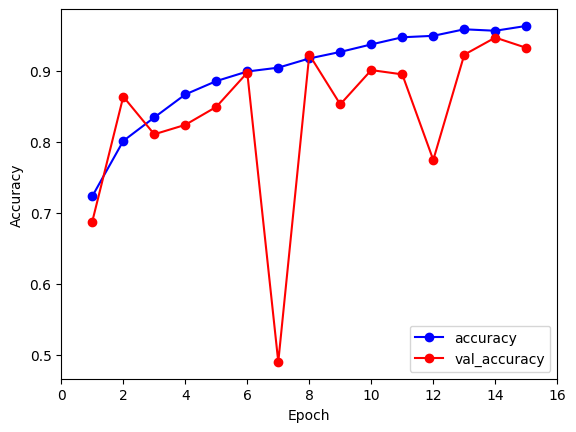

In [24]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], 'b-o', label='accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0, 16)
plt.legend(loc='lower right')

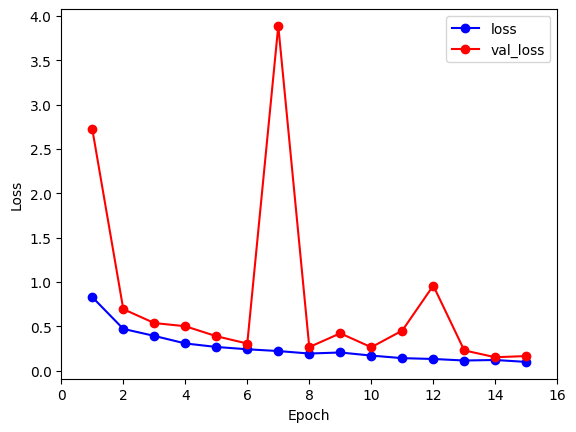

In [25]:
plt.plot(epochs,history.history['loss'], 'b-o', label='loss')
plt.plot(epochs, history.history['val_loss'], 'r-o', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 16)
plt.legend(loc='upper right')

### Evaluate the CNN Model on the Test Set

In [11]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.9290 - loss: 0.2034
Test Loss: 0.2033822238445282
Test Accuracy: 0.9289940595626831


### Run the model on the test set

In [12]:
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step


In [13]:
y_true = test_data.classes

***Select test data images with their predicted label vs their actual label***

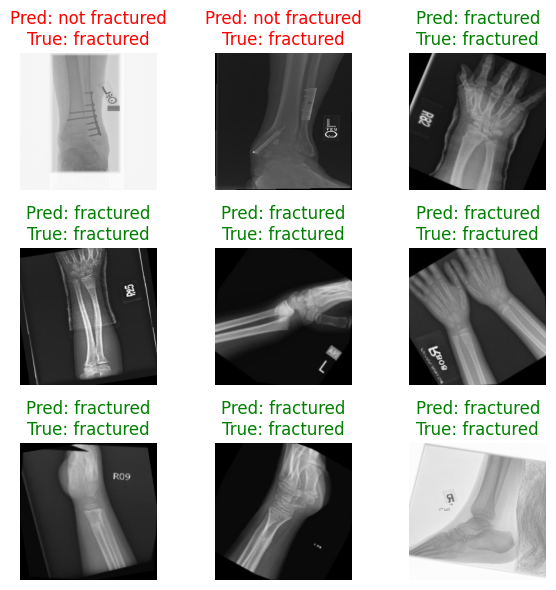

In [14]:
class_names = list(test_data.class_indices.keys())

num_images = 9

plt.figure(figsize=(6, 6))

for i in range(num_images):
    img, _ = test_data[i]  
    img = img[0]           

    pred_label = class_names[y_pred_classes[i].item()]
    true_label = class_names[y_true[i]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()

### Confusion Matrix

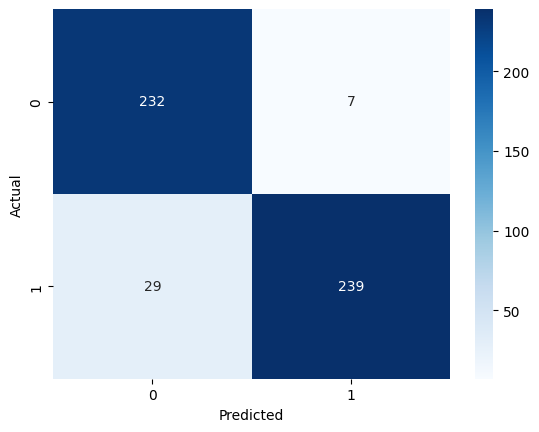

In [15]:
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       239
           1       0.97      0.89      0.93       268

    accuracy                           0.93       507
   macro avg       0.93      0.93      0.93       507
weighted avg       0.93      0.93      0.93       507

